In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class BHBHdatset(torch.utils.data.Dataset):
    def __init__(self, df, input_cols, target_cols, n_bins=100, scale_data=True):
        
        counts, bins = torch.histogram(torch.from_numpy(df[target_cols].values), bins=n_bins, density=True)
        
        self.X = torch.from_numpy(df[input_cols].values)
        self.y = counts*(bins[1]-bins[0])
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i]

In [3]:
# torch.manual_seed(42)
bhbh = pd.read_csv('BHBH.csv')
bhbh = bhbh.fillna(0)
bhbh['q'] = bhbh.apply(lambda x: x['Mass_0_out']/x['Mass_1_out'] if (x['Mass_1_out'] > x['Mass_0_out']) else x['Mass_1_out']/x['Mass_0_out'], axis=1)

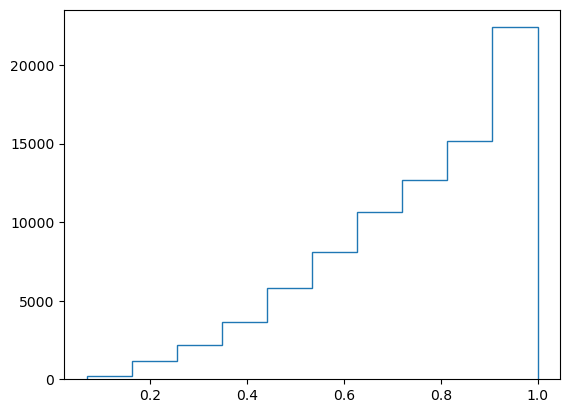

In [6]:
plt.hist(bhbh['q'].values,histtype='step');

In [7]:
data = bhbh
dataset = BHBHdatset(data,
                     ['Mass_0', 'Z_0', 'Mass_1', 'a', 'e'],
                     ['q'],n_bins=20)
trainloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=500,
                                          shuffle=True)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Linear(5, 10)
        self.linear1 = nn.Linear(10, 15)
        self.output = nn.Linear(15, 20)

    # x represents our data
    def forward(self, x):
        x = self.input(x)
        x = torch.relu(x)
        
        x = self.linear1(x)
        x = torch.relu(x)
        
        x = self.output(x)
        x = F.softmax(x, dim=0)
        
        return x

In [10]:
net = Net()
loss_function = nn.KLDivLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

In [11]:
Y = torch.tile(dataset.y, dims=(500, 1)).shape

In [12]:
# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum

# Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, x in enumerate(trainloader):

        x = x.float()

        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs = net(x)

        # Compute loss
        loss = loss_function(outputs, dataset.y.float())

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        #Print statistics
        current_loss += loss.item()

        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %(i + 1, current_loss / 500))
            current_loss = 0.0
    # Process is complete.
    print('Training process has finished.')       

Starting epoch 1


C:\Users\giaco\anaconda3\lib\site-packages\torch\nn\functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Loss after mini-batch     1: -0.000
Loss after mini-batch    11: -0.003
Loss after mini-batch    21: -0.003
Loss after mini-batch    31: -0.003
Loss after mini-batch    41: -0.003
Loss after mini-batch    51: -0.003
Loss after mini-batch    61: -0.003
Loss after mini-batch    71: -0.003
Loss after mini-batch    81: -0.003
Loss after mini-batch    91: -0.003
Loss after mini-batch   101: -0.003
Loss after mini-batch   111: -0.003
Loss after mini-batch   121: -0.003
Loss after mini-batch   131: -0.003
Loss after mini-batch   141: -0.003
Loss after mini-batch   151: -0.003
Loss after mini-batch   161: -0.003
Training process has finished.
Starting epoch 2
Loss after mini-batch     1: -0.000
Loss after mini-batch    11: -0.003
Loss after mini-batch    21: -0.003
Loss after mini-batch    31: -0.003
Loss after mini-batch    41: -0.003
Loss after mini-batch    51: -0.003
Loss after mini-batch    61: -0.003
Loss after mini-batch    71: -0.003
Loss after mini-batch    81: -0.003
Loss after mini-

In [13]:
net.eval()

Net(
  (input): Linear(in_features=5, out_features=10, bias=True)
  (linear1): Linear(in_features=10, out_features=15, bias=True)
  (output): Linear(in_features=15, out_features=20, bias=True)
)

In [14]:
Y_test = net(torch.from_numpy(bhbh[['Mass_0', 'Z_0', 'Mass_1', 'a', 'e']].values).float())

In [15]:
y_test = Y_test.detach().numpy()

In [16]:
counts_test = np.argmax(y_test, axis=1)

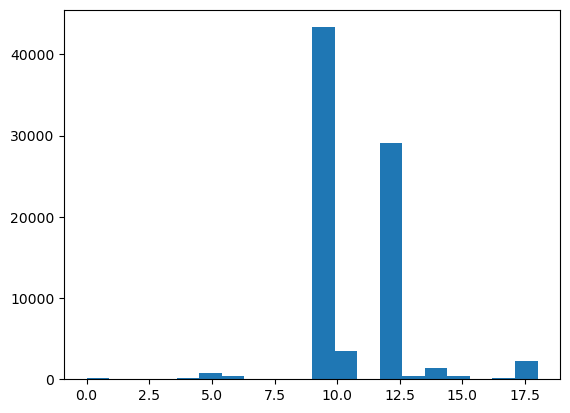

In [17]:
plt.hist(counts_test, bins=20);